# 輸送最適化問題

In [1]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

# データ読み込み
df_tc = pd.read_csv('trans_cost.csv', index_col="工場")
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')


np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))



# 数理モデル作成 #
m1 = model_min()
v1 = {(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}


m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
for i in range(nw):
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]

m1.solve()

# 総輸送コスト計算 #
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j]*value(x)
    
print(df_tr_sol)
print("総輸送コスト:"+str(total_cost))

    F1  F2  F3  F4
工場                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
総輸送コスト:1296.0


最適輸送ルート可視化

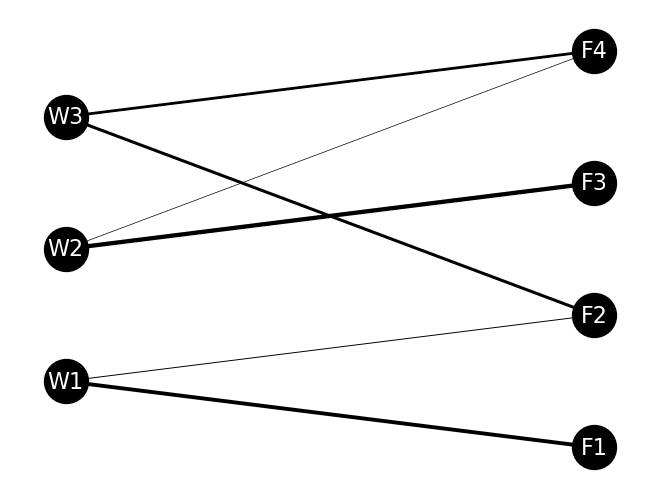

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# データ読み込み
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv('trans_route_pos.csv')

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 辺の設定&エッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            # 辺の追加
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            # エッジの重みの追加
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)
                

# 座標の設定
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
    
# 描画
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

# 表示
plt.show()

最適輸送ルートが制約内か kokokara

In [3]:
import pandas as pd
import numpy as np

# データ読み込み
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

print("\n工場の製品生産に対する需要(demand)\n",df_demand)  #工場の製品生産に対する需要
print("\n倉庫が供給可能な部品数の上限(supply)\n",df_supply)  #倉庫が供給可能な部品数の上限

print("\n制約条件をもとにしたMinimam\n",df_tr_sol)
# 制約条件計算関数
# 需要側
def condition_demand(df_tr_sol,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr_sol[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]): #縦の合計がF[i]より大きいか
            flag[i] = 1
    return flag
            
# 供給側
def condition_supply(df_tr_sol,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr_sol.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]: #横の合計がW[i]より小さいか
            flag[i] = 1
    return flag

print("\n需要条件計算結果:"+str(condition_demand(df_tr_sol,df_demand)))
print("供給条件計算結果:"+str(condition_supply(df_tr_sol,df_supply)))


工場の製品生産に対する需要(demand)
    F1  F2  F3  F4
0  28  29  31  25

倉庫が供給可能な部品数の上限(supply)
    W1  W2  W3
0  35  41  42

制約条件をもとにしたMinimam
     F1  F2  F3  F4
工場                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20

需要条件計算結果:[1. 1. 1. 1.]
供給条件計算結果:[1. 1. 1.]


In [4]:
import pandas as pd

df_material = pd.read_csv('product_plan_material.csv', index_col="製品")
print("\n製品の製造に必要な原料の割合(material)\n\n",df_material)
df_profit = pd.read_csv('product_plan_profit.csv', index_col="製品")
print("\n製品の利益(profit)\n\n",df_profit)
df_stock = pd.read_csv('product_plan_stock.csv', index_col="項目")
print("\n原料の在庫(stock)\n\n",df_stock)
df_plan = pd.read_csv('product_plan.csv', index_col="製品")
print("\n製品の生産量(plan)\n\n",df_plan)


製品の製造に必要な原料の割合(material)

      原料1  原料2  原料3
製品                
製品1    1    4    3
製品2    2    4    1

製品の利益(profit)

       利益
製品      
製品1  5.0
製品2  4.0

原料の在庫(stock)

     原料1  原料2  原料3
項目               
在庫   40   80   50

製品の生産量(plan)

       生産量
製品       
製品1    16
製品2     0


利益を計算

In [5]:
# 利益計算関数
def product_plan(df_profit,df_plan):
    profit = 0
    for i in range(len(df_profit.index)):  #利益
        for j in range(len(df_plan.columns)):  #生産量
            profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]  #利益（i行目) * 生産量(j行目) , 今回の場合 5.0*16 + 4.0*0
    return profit

print("総利益:"+str(product_plan(df_profit,df_plan)))

総利益:80.0


生産最適化問題

In [6]:
import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals


df = df_material.copy()
inv = df_stock

m = model_max()  #最大化問題を解く
v1 = {(i):LpVariable('v%d'%(i),lowBound=0) for i in range(len(df_profit))}

print(df_profit) # 利益表
print(df_material) # 必要な原料
print(v1)  #v1はただの変数
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))  #製品ごとの利益とv1(v0,v1)の積を最大化する（したい）
for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit)) ) <= df_stock.iloc[:,i] #製品に必要な原料の割合*v[i]
m.solve()

df_plan_sol = df_plan.copy()
for k,x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("総利益:"+str(value(m.objective)))
print("\n製品1を15個（利益75)と製品2を5個(利益20)が最大")

print(df_material[:1]*15)
print(df_material[1:2]*5)

      利益
製品      
製品1  5.0
製品2  4.0
     原料1  原料2  原料3
製品                
製品1    1    4    3
製品2    2    4    1
{0: v0, 1: v1}
      生産量
製品       
製品1    15
製品2     5
総利益:95.0

製品1を15個（利益75)と製品2を5個(利益20)が最大
     原料1  原料2  原料3
製品                
製品1   15   60   45
     原料1  原料2  原料3
製品                
製品2   10   20    5


最適生産計画が制約条件内か

In [7]:
# 制約条件計算関数
def condition_stock(df_plan,df_material,df_stock):
    flag = np.zeros(len(df_material.columns)) #制約条件下ならば1に変換される0のlist
    for i in range(len(df_material.columns)):  
        temp_sum = 0
        for j in range(len(df_material.index)):  
            temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
        if (temp_sum<=float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i]+"  使用量:"+str(temp_sum)+", 在庫:"+str(float(df_stock.iloc[0][i])))
    return flag

print("制約条件計算結果:"+str(condition_stock(df_plan_sol,df_material,df_stock)))

原料1  使用量:25.0, 在庫:40.0
原料2  使用量:80.0, 在庫:80.0
原料3  使用量:50.0, 在庫:50.0
制約条件計算結果:[1. 1. 1.]


ロジスティクスネットワーク設計問題

[logistic](https://github.com/SaitoTsutomu/ortoolpy/blob/master/ortoolpy/etc.py)

In [13]:
製品 = list('AB')
需要地 = list('PQ')
工場 = list('XY')
レーン = (2,2)

# 輸送費表 #
tbdi = pd.DataFrame(((j,k) for j in 需要地 for k in 工場), columns=['需要地','工場'])
tbdi['輸送費'] = [1,2,3,1]
print(tbdi)

# 需要表 #
tbde = pd.DataFrame(((j,i) for j in 需要地 for i in 製品), columns=['需要地','製品'])
tbde['需要'] = [10,10,20,20]
print(tbde)

# 生産表 #
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip (工場,レーン) for l in range(nl) for i in 製品), 
                    columns=['工場','レーン','製品','下限','上限'])
tbfa['生産費'] = [1,np.nan,np.nan,1,3,np.nan,5,3]   #np.nanのため、生産費のデータがないところがある。よって8要素あるはずなのに出力は５項目となっている
tbfa.dropna(inplace=True)
tbfa.loc[4,'上限']=10
print(tbfa)

from ortoolpy import logistics_network
a, tbdi2, _ = logistics_network(tbde,tbdi,tbfa)
print(tbfa)
print(tbdi2)  #ここの２つは上のURLから

  需要地 工場  輸送費
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  需要地 製品  需要
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  工場  レーン 製品  下限    上限  生産費
0  X    0  A   0   inf  1.0
3  X    1  B   0   inf  1.0
4  Y    0  A   0  10.0  3.0
6  Y    1  A   0   inf  5.0
7  Y    1  B   0   inf  3.0
True
  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000035  20.0
3  X    1  B   0   inf  1.0  v000036  10.0
4  Y    0  A   0  10.0  3.0  v000037  10.0
6  Y    1  A   0   inf  5.0  v000038   0.0
7  Y    1  B   0   inf  3.0  v000039  20.0
  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000027  10.0
1   P  X    1  B  v000028  10.0
2   Q  X    3  A  v000029  10.0
3   Q  X    3  B  v000030   0.0
4   P  Y    2  A  v000031   0.0
5   P  Y    2  B  v000032   0.0
6   Q  Y    1  A  v000033  10.0
7   Q  Y    1  B  v000034  20.0


c:\Users\yhira\anaconda3\envs\rinko2023\lib\site-packages\ortoolpy\etc.py:1217: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  [tbdi2.groupby(facprd).VarX.sum(), tbfa.groupby(facprd).VarY.sum()], 1


輸送コストとその内訳

In [10]:
print(tbdi2)
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2["輸送費"].iloc[i]*tbdi2["ValX"].iloc[i]
print("総輸送コスト:"+str(trans_cost))

  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0
総輸送コスト:80.0


生産コストとその内訳

In [11]:
print(tbfa)
product_cost = 0
for i in range(len(tbfa.index)):
    product_cost += tbfa["生産費"].iloc[i]*tbfa["ValY"].iloc[i]
print("総生産コスト:"+str(product_cost))

  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000009  20.0
3  X    1  B   0   inf  1.0  v000010  10.0
4  Y    0  A   0  10.0  3.0  v000011  10.0
6  Y    1  A   0   inf  5.0  v000012   0.0
7  Y    1  B   0   inf  3.0  v000013  20.0
総生産コスト:120.0
